In [1]:
import sakuramoti
from sakuramoti.flow_model.raft import RAFT
from torch import Tensor
import numpy as np

class RAFTImageProcessor:
    def __init__(self, img1: str, img2: str):
        self.img1 = sakuramoti.to_0_1(sakuramoti.imread(img1))
        self.img2 = sakuramoti.to_0_1(sakuramoti.imread(img2))
        self.padder = sakuramoti.Padder(self.img1)

    def preprocess(self):
        img1, img2 = self.padder.pad(self.img1, self.img2)
        return img1[None], img2[None]
    
    def postprocess(self, *args: Tensor) -> list[Tensor] | Tensor:
        results = []             
        for arg in args:
            results.append(self.padder.unpad(arg))
        if len(results) == 1:
            return results[0]
        return results

    def __call__(self):
        img1, img2 = self.preprocess()
        return img1, img2
    
    def visualize(self):
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            raise ImportError("matplotlib is not installed. Please install it with 'pip install matplotlib'.")
        img1_np = sakuramoti.to_0_255(self.img1).permute(1, 2, 0).numpy()
        img2_np = sakuramoti.to_0_255(self.img2).permute(1, 2, 0).numpy()
        plt.figure(figsize=(16, 9))
        plt.imshow(np.concatenate([img1_np, img2_np], axis=1))
        plt.show()

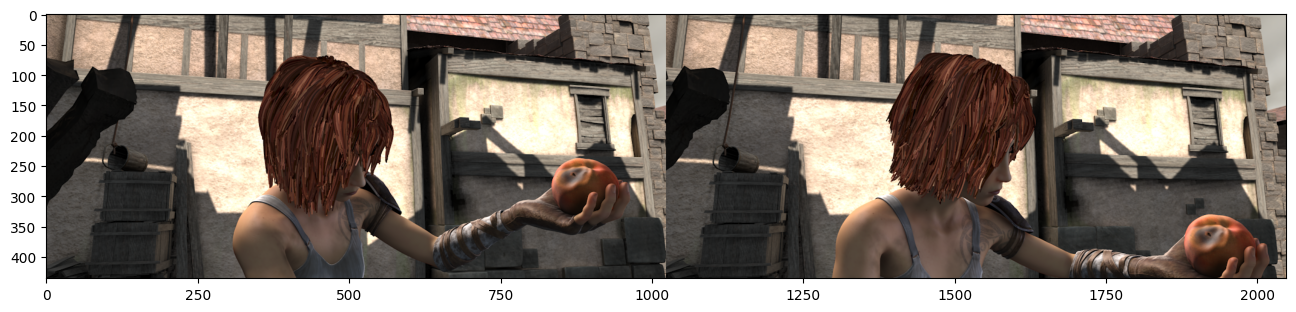

In [2]:
model = RAFT()
processor = RAFTImageProcessor(
    "../artifacts/RAFT/demo-frames/frame_0016.png", "../artifacts/RAFT/demo-frames/frame_0025.png"
)
img1, img2 = processor()
_, flow_forward = model.pred(img1, img2, iters=20)
_, flow_backward = model.pred(img2, img1, iters=20)
flow_forward = processor.postprocess(flow_forward)
flow_backward = processor.postprocess(flow_backward)
processor.visualize()

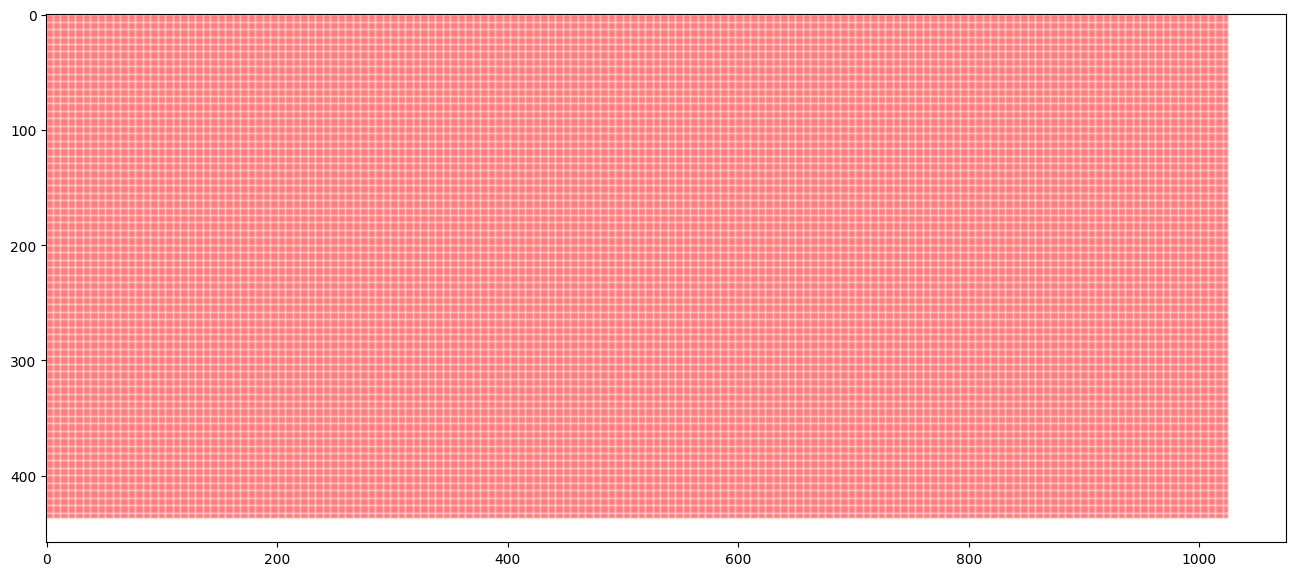

In [3]:
from sakuramoti.visualizer.utils import show_grid
from sakuramoti.geometry.grid import generate_grid

_, _, h, w = flow_forward.shape
grid = generate_grid(h, w, device='cpu')[None]
show_grid(grid)


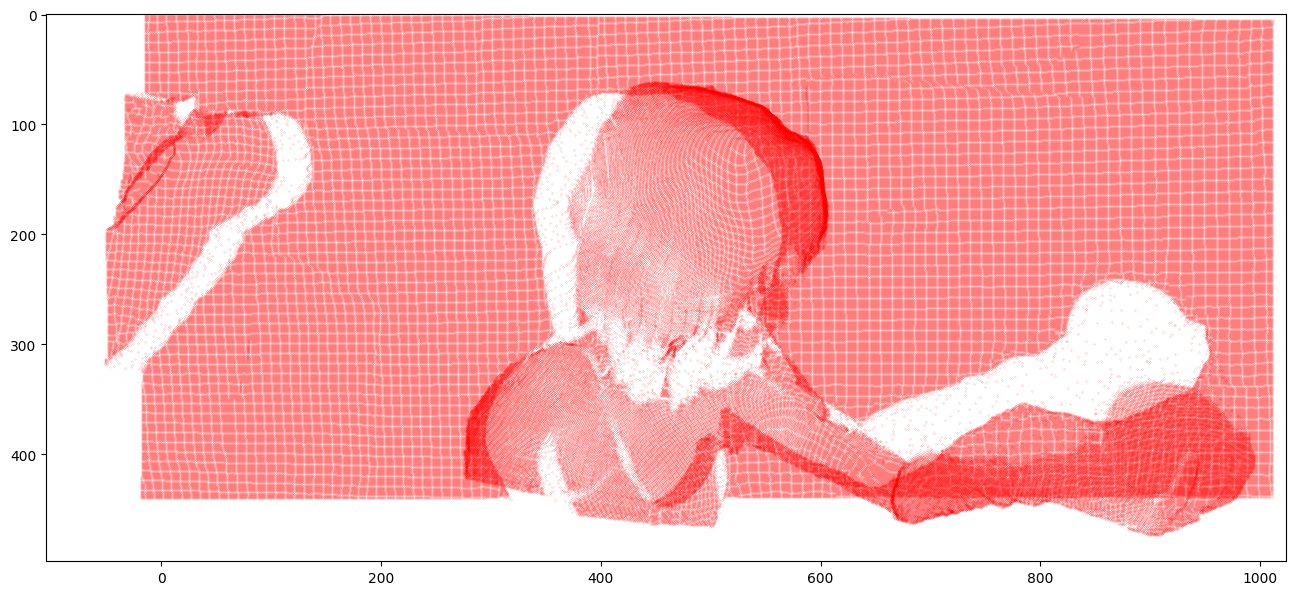

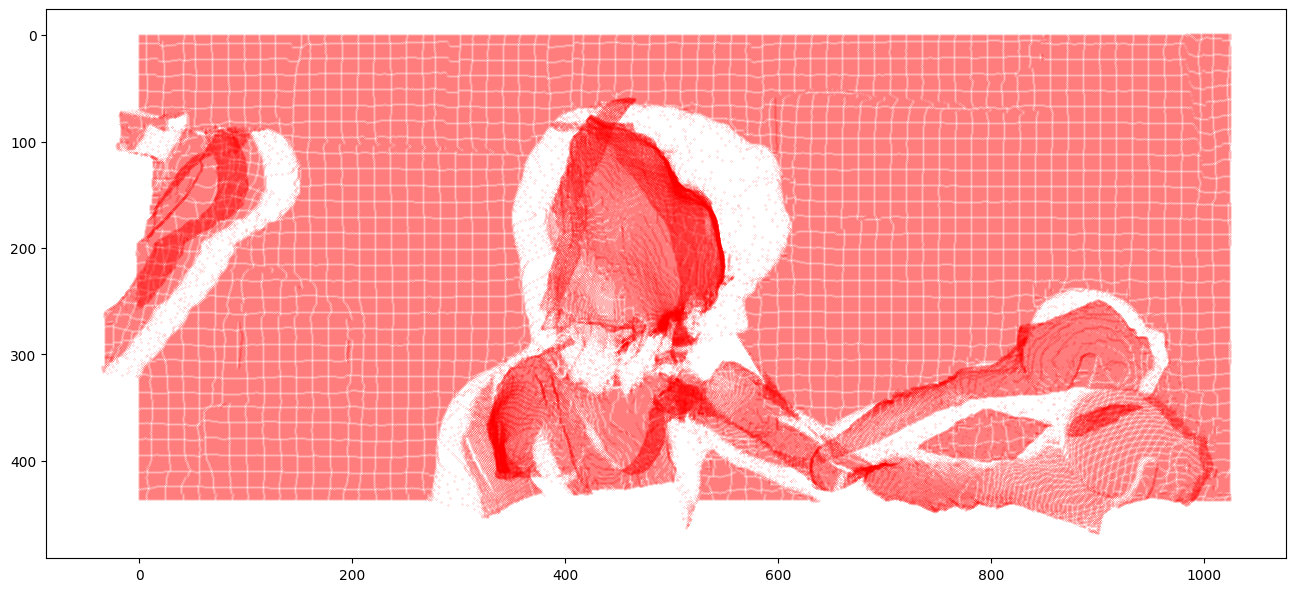

torch.Size([1, 2, 436, 1024])


In [4]:
from matplotlib.pylab import f


grid_x = grid.permute(0, 3, 1, 2)
coord2 = grid_x + flow_forward
show_grid(coord2.permute(0, 2, 3, 1))

coord2_inv = grid_x + flow_forward + flow_backward
show_grid(coord2_inv.permute(0, 2, 3, 1))
print(coord2_inv.shape)

In [5]:
import torch.nn.functional as F
from sakuramoti.geometry.grid import normalize_coords

grid = generate_grid(h, w, device='cpu').permute(2, 0, 1)[None] # [1, 2, h, w]
grid_normed = normalize_coords(grid.squeeze().permute(1, 2, 0), h, w, no_shift=False)  # [h, w, 2]

In [6]:
print(flow_forward.shape)

# i -> j
coord2 = grid + flow_forward # [1, 2, h, w]
coord2_normed = normalize_coords(coord2.squeeze().permute(1, 2, 0), h, w, no_shift=False)  # [h, w, 2]
# j -> i
feature_21_sampled = F.grid_sample(flow_backward, coord2_normed[None], align_corners=True) # [1, 2, h, w]


torch.Size([1, 2, 436, 1024])


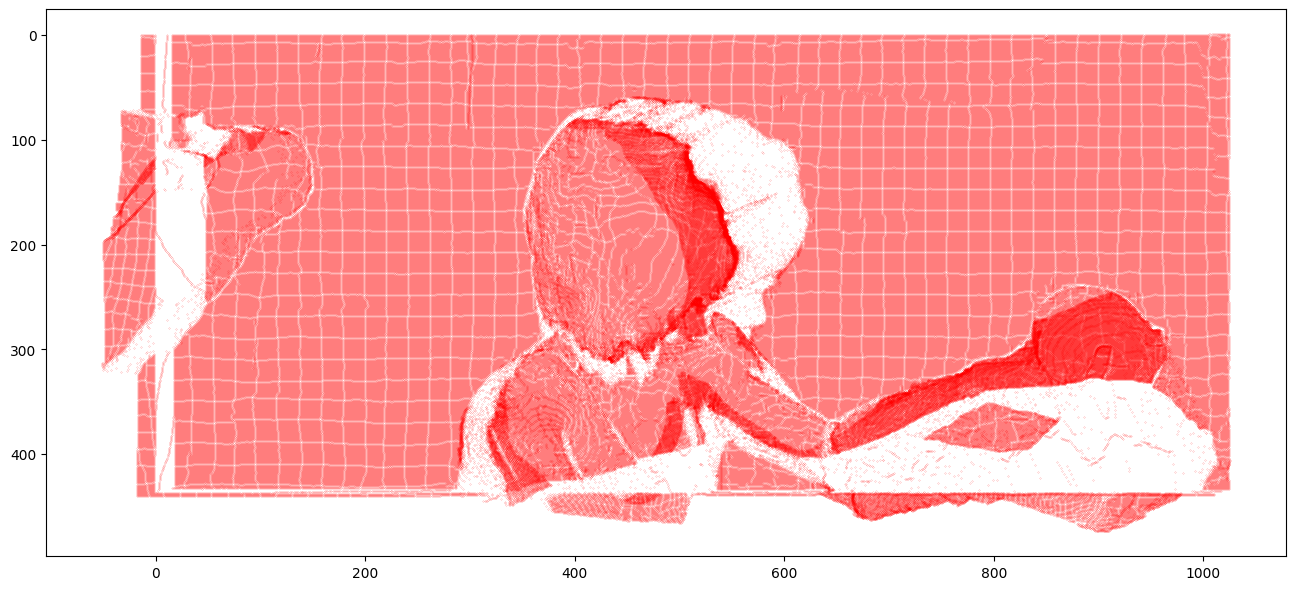

In [7]:
map_i = flow_forward + feature_21_sampled
show_grid(map_i+grid)

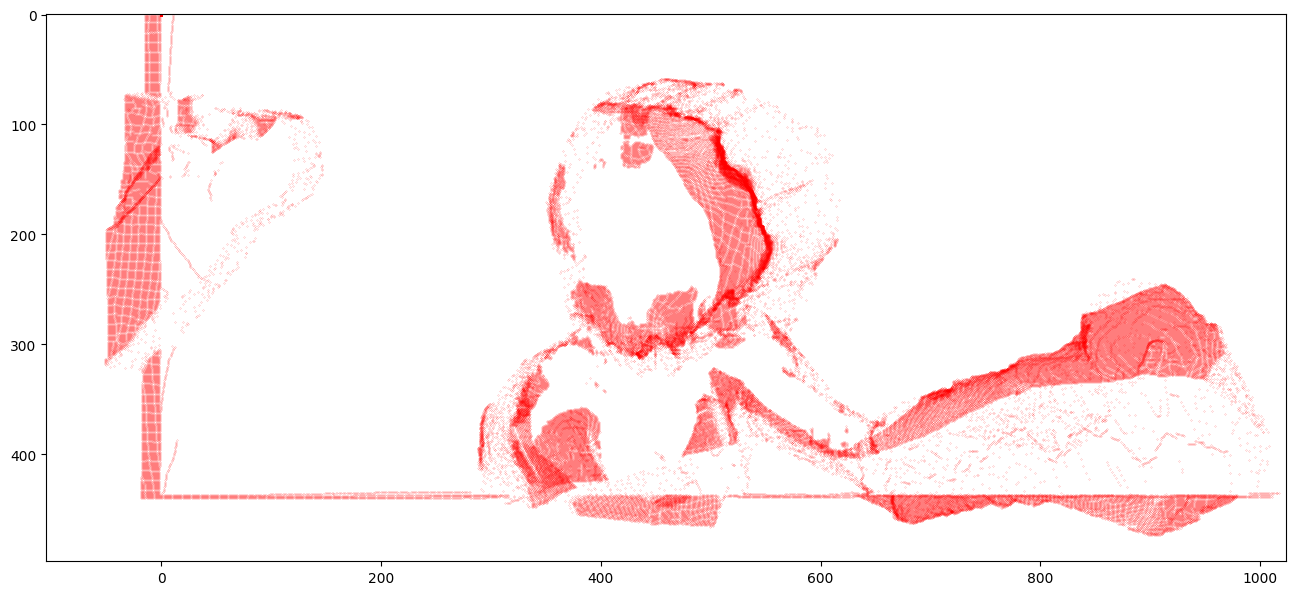

In [8]:
import torch
fb_discrepancy = torch.norm(map_i.squeeze(), dim=0)
mask_cycle = fb_discrepancy > 3.0
show_grid((grid + map_i) * mask_cycle)

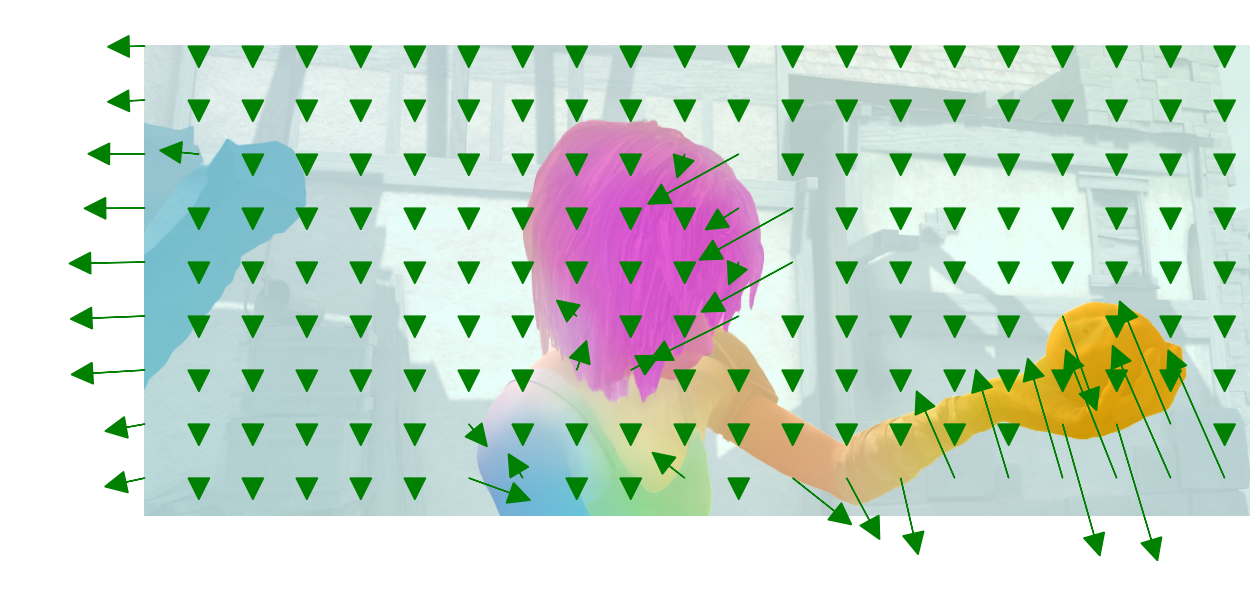

In [9]:
import matplotlib.pyplot as plt
import numpy as np 
import random
from sakuramoti.visualizer.flow_vis import flow_to_image
im1, im2 = processor.img1, processor.img2

im1 = sakuramoti.to_0_255(im1.permute(1, 2, 0)).numpy()
im2 = sakuramoti.to_0_255(im2.permute(1, 2, 0)).numpy()
#print(im1)
im1_rgba = np.dstack((im1 / 255.0, np.ones((im1.shape[0], im1.shape[1], 1))))
im2_rgba = np.dstack((im2 / 255.0, np.ones((im2.shape[0], im2.shape[1], 1)) * 0.5))  # Adjust alpha for transparency
a = flow_to_image(flow_forward)
ap = a[0].permute(1, 2, 0).numpy()
aa = np.dstack((ap / 255.0, np.ones((ap.shape[0], ap.shape[1], 1))))
fig, ax = plt.subplots(figsize=(16, 9))

ax.imshow(im1_rgba)
#ax.imshow(im2_rgba, alpha=0.5)
ax.imshow(aa, alpha=0.8)
ax.axis('off')

h, w = im1.shape[:2]  # Get the height and width of the image
grid_pairs = [(i, j) for i in range(0, h, 50) for j in range(0, w, 50)]
for (i, j) in grid_pairs:
    #ax.arrow(j, i, flow_forward[0][0][i][j], flow_forward[0][1][i][j], head_width=20, head_length=20, fc='blue', ec='blue')
    #ax.arrow(j, i, flow_backward[0][0][i][j], flow_backward[0][1][i][j], head_width=20, head_length=20, fc='red', ec='red')
    #ax.arrow(j, i, feature_21_sampled[0][0][i][j], feature_21_sampled[0][1][i][j], head_width=20, head_length=20, fc='green', ec='green')
    ax.arrow(j, i, map_i[0][0][i][j]* mask_cycle[i][j], map_i[0][1][i][j]* mask_cycle[i][j], head_width=20, head_length=20, fc='green', ec='green')
plt.show()
